# **TP 2: Expectation-Maximisation algorithm - Importance sampling**

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm, multivariate_normal
import pandas as pd
import warnings
import seaborn as sns
import time
warnings.filterwarnings('ignore')

## **Exercise 1: Discrete distributions**

### **Question 2**

In [103]:
def inverse_cdf_z(K, y, cdf_z_discrete):
  '''
  Return the inverse CDF of Z.
  Input:
    K: number of gaussians in the mixture
  '''
  for k in range(K):
    if cdf_z_discrete[k]>= y:
      return k

def sample_Y(K, pi, v):
  #sample a uniform([0,1])
  U = np.random.uniform(size=1)
  cdf_z = np.cumsum(pi) # [F_z(1), ..., F_z(K)]
  #compute the CDF inverse of the cdf
  return v[inverse_cdf_z(K, U, cdf_z)]

### **Question 3**

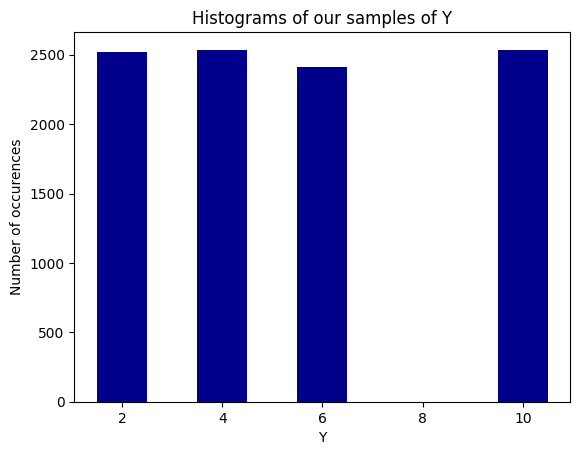

values: [ 2  4  6 10]
empirical p: [0.252 0.254 0.241 0.253]
target p: [0.25, 0.25, 0.25, 0.25]


In [104]:
### TEST ###
N=10000 #number of samples generated
K=4
pi= [1/4]*4
v=[2, 4, 6, 10]

samples = [sample_Y(K, pi, v) for _ in range(N)] #N samples with our algorithm

bins = np.arange(np.min(v)-1/2, np.max(v)+1, 1)
plt.hist(samples, bins=bins, color='darkblue')
plt.title("Histograms of our samples of Y")
plt.ylabel("Number of occurences")
plt.xlabel("Y")
plt.show()


vals, counts = np.unique(samples, return_counts=True)
emp_p = counts / N
print("values:", vals)
print("empirical p:", emp_p)
print("target p:", pi)

## **Exercise 2: Gaussian mixture model and the EM algorithm**

### **Question 2**

In [105]:
def sample_gmm(n, alpha, mu, sigma):
  """
  Sample n points from a Gaussian mixture model.

  Parameters
  ----------
  n : int
      Number of samples to draw.
  alpha : array-like of shape (m,)
      Mixture weights that sum to 1.
  mu : array-like of shape (m, d)
      Means of the m Gaussian components.
  sigma : array-like of shape (m, d, d) or (m,)
      Covariance matrices in d dimensions, or variances if d = 1.

  Returns
  -------
  X : ndarray of shape (n, d)
      Sampled data points.
  Z : ndarray of shape (n,)
      Component indices from which each point was drawn.
  """
  m = len(mu) #number of gaussians in the mixture
  d = mu[0].size
  # print(f"m = {m}, d={d}")
  cdf_z = np.cumsum(alpha)
  U = np.random.uniform(size = n) #shape: (n,)
  #We first need to sample Z
  Z = np.array([inverse_cdf_z(m, u, cdf_z) for u in U]) #shape: (n,)
  # print(Z)
  X = np.empty((n, d))
  for j in range(m):
    #knowing that Z=j, we know the law of X_i
    idx = np.where(Z == j)[0] #indixes of the Z_i such that Z_i = j
    if d>1: #if we are not in 1D
      X[idx] = np.random.multivariate_normal(mu[j], sigma[j], size=idx.size) #law of X_i given Z_i=j
    else:
      res = np.random.normal(mu[j], sigma[j], size=idx.size) #law of X_i given Z_i=j
      X[idx] = np.reshape(res, (-1, 1))
  return X, Z


We test the following 1-D Gaussian mixture with (K=2), weights $α=[0.3,0.7]$, means $\mu=[0,5]$, and standard deviations $σ=[1,1]$:
$$
p(x)=0.3\mathcal N(x;0,1)+0.7\mathcal N(x;5,1).
$$


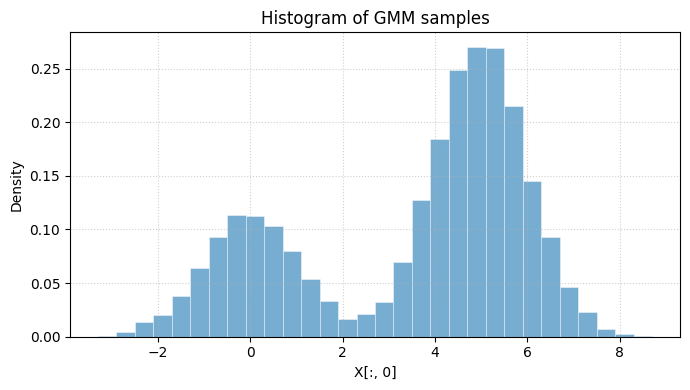

Proportion of samples in cluster 0: 30.0200 %
Proportion of samples in cluster 1: 69.9800 %


In [106]:
def plot_gmm(samples_X, title, col=None, bins="auto", density=True, rug=True, show_stats=True, ax=None):
  '''
  Plot the histogram of the samples given in input
  '''
  X = np.asarray(samples_X)
  if X.ndim == 2:
      if col is None:
          col = 0
      x = X[:, col].ravel()
      x_label = f"X[:, {col}]"
  else:
      x = X.ravel()
      x_label = "X"

  edges = np.histogram_bin_edges(x, bins=bins)

  if ax is None:
      fig, ax = plt.subplots(figsize=(7, 4))
  else:
      fig = ax.figure

  ax.hist(x, bins=edges, density=density, alpha=0.6,
          edgecolor="white", linewidth=0.5, label="Samples")

  ax.set_title(title or "Histogram of GMM samples")
  ax.set_xlabel(x_label)
  ax.set_ylabel("Density" if density else "Count")
  ax.grid(True, linestyle=":", alpha=0.6)

  if rug:
      ymin, ymax = ax.get_ylim()
      y0 = ymin + 0.02 * (ymax - ymin)
      ax.plot(x, np.full_like(x, y0), "|", alpha=0.5)

  if show_stats:
      mu = float(np.mean(x))
      sd = float(np.std(x, ddof=1))
      ax.axvline(mu, linestyle="--", linewidth=1.5, label=f"mean={mu:.3f}")
      ax.axvline(mu - sd, linestyle=":", linewidth=1.2, label=f"±1σ={sd:.3f}")
      ax.axvline(mu + sd, linestyle=":", linewidth=1.2)
      ax.legend()

  fig.tight_layout()
  plt.show()
  return ax

### TEST ###
n=10000
alpha = np.array([0.3, 0.7])
mu = np.array([0, 5])

sigma= np.array([1, 1])

samples_X, samples_Z = sample_gmm(n, alpha, mu, sigma)

proportions_Z = [np.sum(samples_Z == j , axis=0)*100/len(samples_Z) for j in range(len(alpha))] #contrais the proportion of observations in each cluster
plot_gmm(samples_X, title="Histogram of GMM samples", show_stats=False, rug=False)
for i in range(len(alpha)):
  print(f"Proportion of samples in cluster {i}: {proportions_Z[i]:.4f} %")


### **Question 3**

We will implement the EM algorithm for the GMM, and we choose to initialize the clusters using KMeans algorithm, and thus to start with step M.

In [107]:
def EM(samples_X, m, max_iter, tol):
  """
  Run EM to fit a Gaussian Mixture Model with m components.

  Parameters
  ----------
  samples_X : array-like of shape (n, d)
      Data points.
  m : int
      Number of Gaussian components.
  max_iter : int
      Maximum number of EM iterations.
  tol : float
      Relative improvement threshold on the log-likelihood for stopping.

  Returns
  -------
  parameters : dict
      {"alpha": (m,), "mu": (m, d), "sigma": (m, d, d)} estimated mixture params.
  log_likehood_track : list of float
      Log-likelihood values at each EM iteration.
  """
  n, d = samples_X.shape
  # Initialization for E step
  km = KMeans(n_clusters=m)
  km.fit(samples_X)
  labels = km.labels_  # shape : (n,)
  tau = np.zeros((n, m))
  tau[np.arange(n), labels] = 1.0  # set the predictions as one hot
  log_likehood_track = [] #tracks the evolution of the log likelihood
  parameters = {}
  iter_count = 0
  prev_loglik = -np.inf #observed log likelihood
  #we continue until the number of iterations < max_iter
  #and growth of log likelihood is < tol
  while True:
    # M-step
    alpha = np.mean(tau, axis=0)  # (m,)
    mu = np.zeros((m, d))
    sigma = np.zeros((m, d, d))
    for j in range(m):
      n_j = np.sum(tau[:, j])
      mu[j] = (tau[:, j].T @ samples_X) / n_j
      Xc = samples_X - mu[j]
      w = tau[:, j][:, None]
      sigma[j] = (Xc * w).T @ Xc / n_j
      sigma[j] += 1e-6 * np.eye(d)

    parameters["alpha"] = alpha
    parameters["mu"] = mu
    parameters["sigma"] = sigma

    # E-step
    for i in range(n):
      den = 0.0
      vals = []
      for k in range(m):
        v = multivariate_normal(mean=mu[k], cov=sigma[k]).pdf(samples_X[i])
        vals.append(v)
        den += alpha[k] * v
      for j in range(m):
        tau[i, j] = (alpha[j] * vals[j]) / (den + 1e-15)

    # compute observed log-likelihood and decide if we stop
    loglik = 0.0
    for i in range(n):
      s = 0.0
      for j in range(m):
        s += alpha[j] * multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(samples_X[i])
      loglik += np.log(s + 1e-15)
    log_likehood_track.append(loglik)

    impr = (loglik - prev_loglik) / (abs(prev_loglik) + 1e-15)
    if impr < tol:
      break
    prev_loglik = loglik
    iter_count += 1
    if iter_count >= max_iter:
      break

  return parameters, log_likehood_track


### **Question 4**

In [108]:
def plot_compare_gmm(samples_X, samples_pred, title, bins="auto", density=True):
  """
  Compare two 1D sample sets with overlaid histograms.
  """
  x = np.asarray(samples_X).ravel()
  y = np.asarray(samples_pred).ravel()
  edges = np.histogram_bin_edges(np.concatenate([x, y]), bins=bins)

  fig, ax = plt.subplots(figsize=(7, 4))
  ax.hist(x, bins=edges, density=density, alpha=0.55, label="True samples",
          edgecolor="white", linewidth=0.5)
  ax.hist(y, bins=edges, density=density, alpha=0.55, label="Predicted samples",
          edgecolor="white", linewidth=0.5)

  ax.set_title(title or "Histogram comparison: True vs Predicted")
  ax.set_xlabel("Value")
  ax.set_ylabel("Density" if density else "Count")
  ax.legend()
  ax.grid(True, linestyle=":", alpha=0.6)
  fig.tight_layout()
  plt.show()

In [109]:
### TEST ###
#We test for the correct amount of clusters
m=2
n=1000 #number of samples

max_iter=1000
tol=1e-8

alpha = np.array([0.3, 0.7])
mu = np.array([0, 5])
sigma= np.array([1, 1])

samples_X, _ = sample_gmm(n, alpha, mu, sigma)
print(f" Starting EM for {n} samples and {m} clusters:")
start_time = time.time()

pred_parameters, log_likehood = EM(samples_X, m, max_iter, tol)

end_time = time.time()
print(f"Duration of the EM algorithm : {(end_time - start_time):.1f} seconds")

print(f"predicted weights : {list(map(lambda x : float(round(x,2)), pred_parameters["alpha"].flatten()))} | real weights : {alpha}")
print(f"predicted means : {list(map(lambda x : float(round(x,2)), pred_parameters["mu"].flatten()))} | real means : {mu}")
print(f"predicted std : {list(map(lambda x : float(round(x,2)), pred_parameters["sigma"].flatten()))} | real std : {sigma}")

 Starting EM for 1000 samples and 2 clusters:
Duration of the EM algorithm : 9.1 seconds
predicted weights : [0.7, 0.3] | real weights : [0.3 0.7]
predicted means : [5.01, 0.13] | real means : [0 5]
predicted std : [1.06, 0.83] | real std : [1 1]


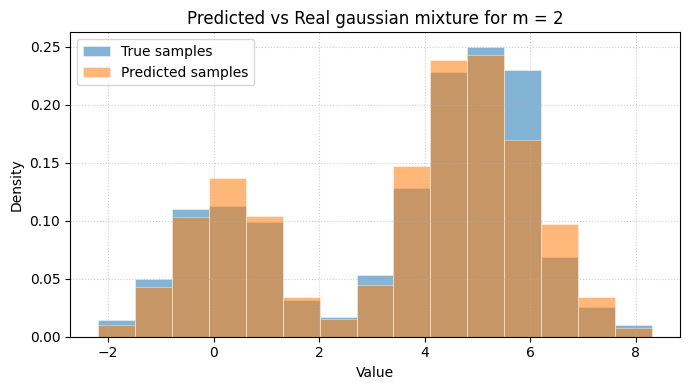

In [110]:
samples_predicted_correct, _ = sample_gmm(n, pred_parameters["alpha"].flatten(), pred_parameters["mu"].flatten(), pred_parameters["sigma"].flatten())
plot_compare_gmm(samples_X, samples_predicted_correct, title=f"Predicted vs Real gaussian mixture for m = {m}")

The EM algorithm is precise when the correct amount of clusters is used to generate samples. Indeed, the estimated parameters are close from the original ones.

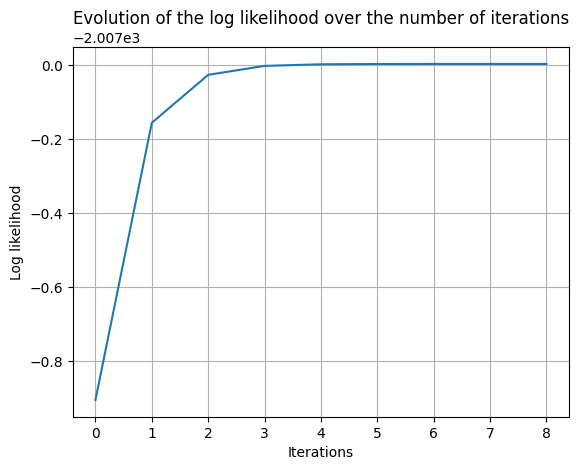

In [111]:
plt.plot(np.arange(len(log_likehood)), log_likehood)
plt.title("Evolution of the log likelihood over the number of iterations")
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")
plt.grid()
plt.show()

Moreover, it converges in only 3 iterations with a precision of $1e^{-6}$.

In [112]:
### TEST ###
#We test for the incorrect amount of clusters
m = 4 # 4 instead of 2

max_iter=1000
tol=1e-4
n = 1000 #number of samples
alpha = np.array([0.3, 0.7])
mu = np.array([0, 5])
sigma= np.array([1, 1])

samples_X, _ = sample_gmm(n, alpha, mu, sigma)
print(f" Starting EM for {n} samples and {m} clusters:")
start_time = time.time()

pred_parameters_modified, log_likehood_incorrect = EM(samples_X, m, max_iter, tol)

end_time = time.time()
duration = end_time - start_time

print(f"Duration of the EM algorithm : {duration:.1f} seconds.")

print(f"predicted weights : {list(map(lambda x: float(round(x,2)), pred_parameters_modified["alpha"].flatten()))} | real weights : {alpha}")
print(f"predicted means : {list(map(lambda x: float(round(x,2)), pred_parameters_modified["mu"].flatten()))} | real means : {mu}")
print(f"predicted std : {list(map(lambda x: float(round(x,2)),pred_parameters_modified["sigma"].flatten()))} | real std : {sigma}")

 Starting EM for 1000 samples and 4 clusters:
Duration of the EM algorithm : 25.5 seconds.
predicted weights : [0.31, 0.26, 0.37, 0.07] | real weights : [0.3 0.7]
predicted means : [4.46, -0.2, 5.54, 2.04] | real means : [0 5]
predicted std : [0.49, 0.63, 0.55, 1.29] | real std : [1 1]


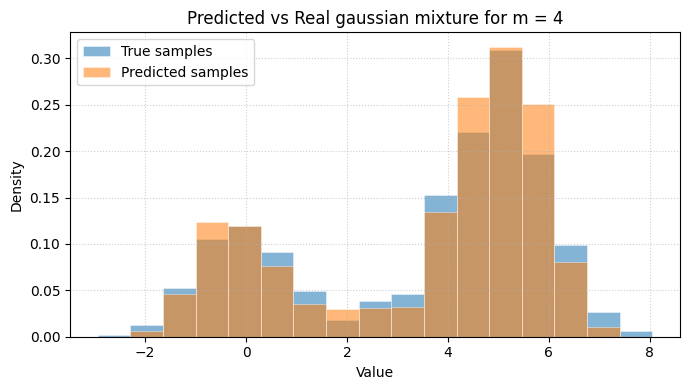

In [113]:
samples_predicted_incorrect, _ = sample_gmm(n, pred_parameters_modified["alpha"].flatten(), pred_parameters_modified["mu"].flatten(), pred_parameters_modified["sigma"].flatten())
plot_compare_gmm(samples_X, samples_predicted_incorrect, title=f"Predicted vs Real gaussian mixture for m = {m}")

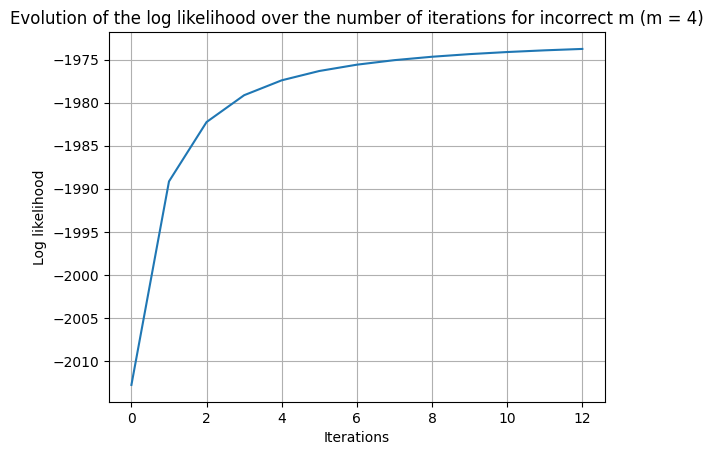

In [114]:
plt.plot(np.arange(len(log_likehood_incorrect)), log_likehood_incorrect)
plt.title(f"Evolution of the log likelihood over the number of iterations for incorrect m (m = {m})")
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")
plt.grid()
plt.show()

EM algorithm is numerically robust (it converges) even when m seems "incorrect", and it still fits the density well as seen on the histogram. Nonetheless, the parameters are no longer interpretable. They just form redundant components around the 2 real modes.

### **Question 5**

In [115]:
#load the data we need
df = pd.read_csv("/content/WPP2024_Demographic_Indicators_Medium.csv")
mask = df['Time'] == 2023 #only keep year 2023
df = df[mask]

CBR, CDR = df["CBR"], df["CDR"]

In [116]:
CBR.describe()

,CBR
count,526.000000
mean,17.764492
std,9.332758
min,4.211000
25%,10.018250
50%,14.813000
75%,23.662750
max,46.358000


In [117]:
CDR.describe()

,CDR
count,526.000000
mean,7.875652
std,2.450994
min,0.930000
25%,6.444000
50%,7.450000
75%,9.140750
max,25.580000


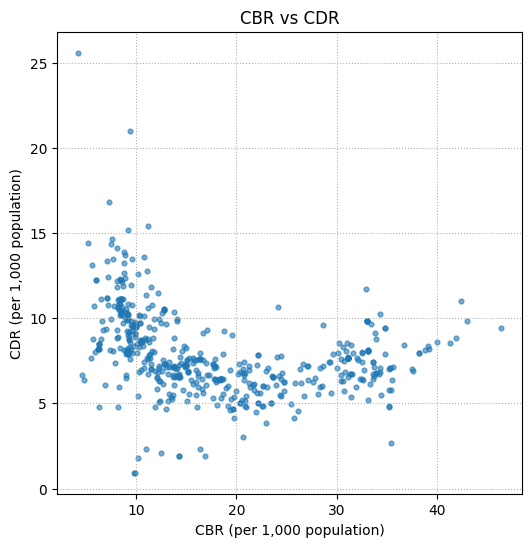

In [118]:
#scatter graph
plt.figure(figsize=(6, 6))
plt.scatter(CBR, CDR, s=12, alpha=0.6)
plt.xlabel("CBR (per 1,000 population)")
plt.ylabel("CDR (per 1,000 population)")
plt.title("CBR vs CDR")
plt.grid(True, linestyle=":")

A GMM is reasonable as an exploratory density/clustering tool here, but it won't capture the curved, heteroskedastic structure perfectly.

### **Question 6**

For $m=3$, we can interpret clusters as follows:

**Cluster 1 — Low-fertility, ageing:**  

Low CBR and moderate CDR, typical of late-transition or high-income countries. Population growth is near zero or slightly negative due to older age structures. This phenomenon can be noticed in countries such as Japan, Italy and Germany.

**Cluster 2 — Mid-transition:**  

Medium CBR and low CDR. These countries are still above replacement fertility and have clear positive natural growth. This phenomenon can be noticed in Egypt or Indonesia.

**Cluster 3 — High-fertility:**  

Very high CBR with moderate CDR, common in younger populations. Natural growth is high because fertility remains far above replacement. This phenomenon can mainly be observed African countries such as Niger or Mali.

### **Question 7**

m    |   BIC
------------------
2    |   2915.683
3    |   2868.166
4    |   2875.113
5    |   2869.425
Best model for m = 3


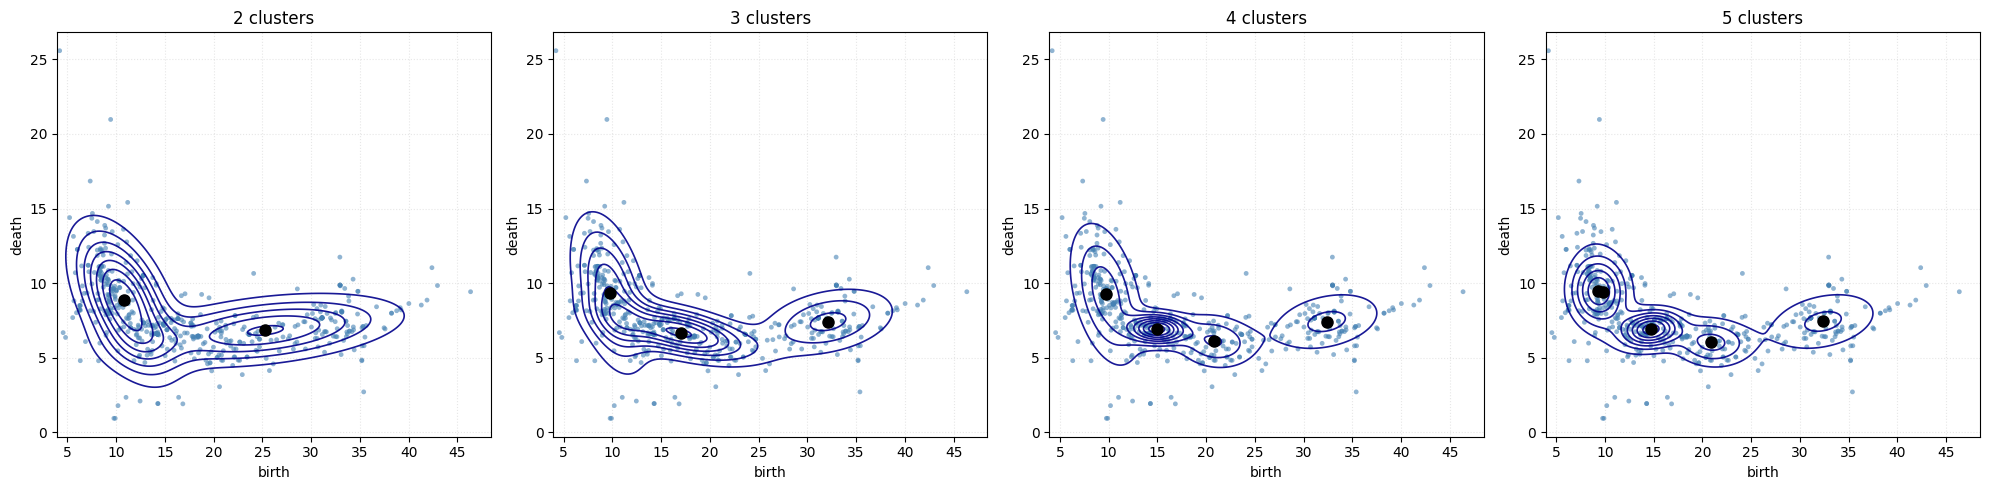

In [119]:
np.random.seed(24) #we set a seed here because reproducibility is important for this question in order to not change the clusters

list_m = [2, 3, 4, 5]
max_iter = 1000
tol = 1e-4
samples = np.vstack([CBR, CDR]).T  # Shape (n, 2)
list_param = []
list_BIC = []
n, d = samples.shape


# Compute BIC for each m
for m in list_m:
    predicted_params, loglik = EM(samples, m, max_iter=max_iter, tol=tol)
    list_param.append(predicted_params)
    # Number of degrees of freedom
    p = (m - 1) + m * d + m * (d * (d + 1) // 2)
    list_BIC.append(-loglik[-1] + 0.5 * p * np.log(n))

print("m    |   BIC")
print("------------------")
for m, bic in zip(list_m, list_BIC):
    print(f"{m:.0f}    |   {bic:.3f}")

# Choose best model (smallest BIC)
best_idx = int(np.argmin(list_BIC))
print(f"Best model for m = {list_m[best_idx]}")

# Prepare grid for contour plot
x_min, x_max = np.percentile(CBR, [1, 99])
y_min, y_max = np.percentile(CDR, [1, 99])
pad_x = 0.05 * (x_max - x_min)
pad_y = 0.05 * (y_max - y_min)
x = np.linspace(x_min - pad_x, x_max + pad_x, 200)
y = np.linspace(y_min - pad_y, y_max + pad_y, 200)
Xg, Yg = np.meshgrid(x, y)
pts = np.column_stack([Xg.ravel(), Yg.ravel()])

# Create subplots for each m
fig, axes = plt.subplots(1, len(list_m), figsize=(5 * len(list_m), 5))
if len(list_m) == 1:
    axes = [axes]

for idx, m in enumerate(list_m):
    ax = axes[idx]
    params = list_param[idx]
    alpha_hat = params["alpha"]
    mu_hat = params["mu"]
    Sigma_hat = params["sigma"]

    # Scatter plot
    ax.scatter(CBR, CDR, s=12, alpha=0.6, color='steelblue', edgecolors='none')

    # Compute mixture density on grid
    Z = np.zeros(pts.shape[0])
    for j in range(m):
        Z += alpha_hat[j] * multivariate_normal(mean=mu_hat[j], cov=Sigma_hat[j]).pdf(pts)
    Z = Z.reshape(Xg.shape)

    # Contour plot
    cs = ax.contour(Xg, Yg, Z, levels=8, linewidths=1.2, alpha=0.9, colors='darkblue')

    # Plot cluster centers
    for j in range(m):
        ax.plot(mu_hat[j, 0], mu_hat[j, 1], 'ko', markersize=8, markerfacecolor='black')

    # Labels and title
    ax.set_xlabel("birth")
    ax.set_ylabel("death")
    ax.set_title(f"{m} cluster{'s' if m > 1 else ''}")
    ax.grid(True, linestyle=":", alpha=0.3)

plt.tight_layout()
plt.show()


In [120]:
#We print the parameters
np.set_printoptions(precision=3, suppress=True)

for idx, m in enumerate(list_m):
    params = list_param[idx]
    alpha_hat = params["alpha"]
    mu_hat = params["mu"]
    Sigma_hat = params["sigma"]

    print(f"\n===== Results for m = {m} =====")
    for j in range(m):
        print(f"Component {j+1}:")
        print(f"  alpha = {alpha_hat[j]:.3f}")
        print(f"  mu    = [{mu_hat[j, 0]:.3f}, {mu_hat[j, 1]:.3f}]")
        print("  Sigma =")
        print(f"    [{Sigma_hat[j, 0, 0]:.3f}  {Sigma_hat[j, 0, 1]:.3f}]")
        print(f"    [{Sigma_hat[j, 1, 0]:.3f}  {Sigma_hat[j, 1, 1]:.3f}]")



===== Results for m = 2 =====
Component 1:
  alpha = 0.481
  mu    = [25.313, 6.824]
  Sigma =
    [61.925  4.276]
    [4.276  1.886]
Component 2:
  alpha = 0.519
  mu    = [10.777, 8.849]
  Sigma =
    [8.521  -4.226]
    [-4.226  7.827]

===== Results for m = 3 =====
Component 1:
  alpha = 0.379
  mu    = [17.009, 6.669]
  Sigma =
    [19.057  -2.655]
    [-2.655  1.289]
Component 2:
  alpha = 0.386
  mu    = [9.770, 9.342]
  Sigma =
    [5.284  -3.081]
    [-3.081  9.344]
Component 3:
  alpha = 0.235
  mu    = [32.136, 7.412]
  Sigma =
    [18.220  1.934]
    [1.934  1.983]

===== Results for m = 4 =====
Component 1:
  alpha = 0.174
  mu    = [14.968, 6.922]
  Sigma =
    [3.205  -0.063]
    [-0.063  0.396]
Component 2:
  alpha = 0.174
  mu    = [20.806, 6.101]
  Sigma =
    [6.820  -0.432]
    [-0.432  1.358]
Component 3:
  alpha = 0.230
  mu    = [32.368, 7.419]
  Sigma =
    [16.432  1.784]
    [1.784  1.999]
Component 4:
  alpha = 0.422
  mu    = [9.727, 9.247]
  Sigma =
    [5

**Interpretation**

As we increase the number of components, EM first recovers the main large groups in the data, then progressively splits these groups into several nearby Gaussians that together approximate elongated or complex shapes. For $m$ bigger than $4$, the extra components no longer correspond to new meaningful clusters, they just refine the density locally to slightly improve likelihood.

## **Exercise 3: Importance sampling**

### **3.A  Poor Importance Sampling**


Let's implement the following functions. $\forall x  \in \mathbb{R}$:

- $
f(x) = 2 \sin\!\left(\frac{\pi}{1.5}\,x\right)\, \mathbf{1}_{\mathbb{R}_+}(x)
$
- $p(x)= x^{1.65-1}\, e^{-x^{2}/2} \, \mathbf{1}_{\mathbb{R}_+}(x)$
- $q(x)= \frac{2}{\sqrt{2\pi\,(1.5)}} \exp\!\left(-\frac{((0.8)-x)^{2}}{2(1.5)}\right)$

In [121]:
def f(x):
  """
  Computes the value of function f at point x.
  Parameters:
   -x : np.array or float
  Returns:
   - value of f at x: np.array or float
  """
  x = np.asarray(x) #for vectorizing
  return 2*np.sin(np.pi*x/1.5)*(x>=0)

def p(x):
  """
  Computes the value of function p at point x.
  Parameters:
   -x : np.array or float
  Returns:
   - value of p at x: np.array or float
  """
  x= np.asarray(x) #for vectorizing
  return x**(0.65) * np.exp(-0.5 * x**2)*(x>=0)

def q(x, mu):
  """
  Computes the value of function q at point x.
  Parameters:
   -x : np.array or float
   -mu (mean of q): float
  Returns:
   - value of q at x: np.array or float
  """
  x= np.asarray(x) #for vectorizing
  return 2*np.exp(-((mu - x)**2)/3)/np.sqrt(3*np.pi)

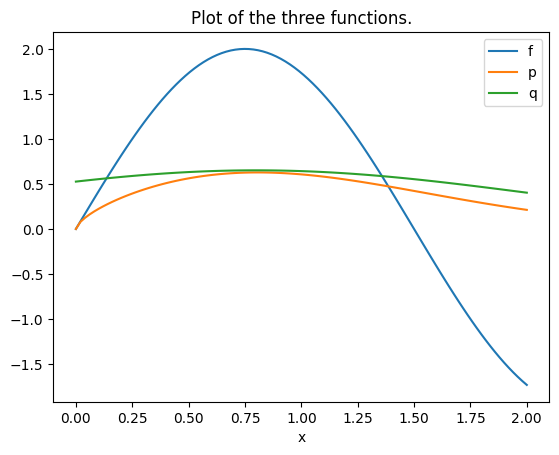

In [122]:
### Visualization ###

mu = 0.8 #mean of q

xx = np.linspace(0, 2, 100)
fx = f(xx)
px = p(xx)
qx = (lambda x : q(x,mu))(xx)

plt.plot(xx, fx, label="f")
plt.plot(xx, px, label='p')
plt.plot(xx, qx, label="q")
plt.title("Plot of the three functions.")
plt.legend()
plt.xlabel('x')
plt.show()

#### **Question 1**

Since neither $p$ or $q$ are density distributions, we will use importance sampling with normalized weights to approximate $\mathbb{E}_p[f(X)]$. Let $(Y_1, ..., Y_n)$ be i.i.d samples of random variables having $q$ for density distribution. The importance sampling estimator is given by:

$$
\hat{\delta}_N := \frac{1}{N}\sum_{i=1}^{N}\tilde{ω_i}\,f(Y_i) \quad\text{with}\quad
\omega_i=\frac{p(Y_i)}{q(Y_i)} \quad \text{and } \tilde{\omega_i} = \frac{ω_i}{\frac{1}{N}\sum_{j=1}^Nω_j}.
$$


In [123]:
def IS(N, mu):
  """
  Compute the estimator delta_N hat.
  Inputs :
   -mu (mean of q) : float or np.array
  Returns :
   - delta_N_hat : float or np.array
  """
  res=0
  Y = np.random.normal(loc=mu, scale=np.sqrt(1.5), size=N) #N sample of random variables with distribution q/2
  Y = np.array(Y[Y>=0]) #only keep Y>=0
  # print(len(Y))
  w = p(Y) / q(Y, mu)
  normalized_w = w/np.mean(w)
  val = normalized_w * f(Y)
  return np.mean(val)

Estimation of the expectation : 0.7338


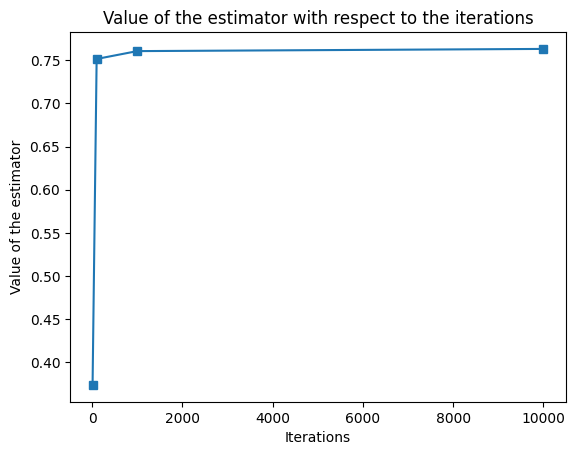

In [124]:
np.random.seed(22)

Ns = [10, 100, 1000, 10000]
mu1 = 0.8 #first choice of mean
mu = mu1 #mean for the density function q

delta_n_hat = IS(Ns[-1], mu)
print(f"Estimation of the expectation : {delta_n_hat:.4f}")
IS_vec = np.vectorize((lambda x: IS(x, mu)))
ISNs = IS_vec(Ns)


plt.xlabel("Iterations")
plt.ylabel("Value of the estimator")
plt.plot(Ns, ISNs, '-s')
plt.title("Value of the estimator with respect to the iterations");

#### **Question 2**

Let's compute the mean and variance empirically.

In [125]:
# Compute empirical mean and variance for different sample sizes

Ns = [10, 100, 1000, 10000]
M = 1000
mu = 0.8

means = []
variances = []
for N in Ns:
    estimates = np.array([IS(N, mu) for _ in range(M)])
    means.append(estimates.mean())
    variances.append(estimates.var(ddof=1))
    print(f"N={N}: mean = {estimates.mean():.4f}, variance = {estimates.var(ddof=1):.6f}")


N=10: mean = 0.7415, variance = 0.248855
N=100: mean = 0.7657, variance = 0.019313
N=1000: mean = 0.7693, variance = 0.002072
N=10000: mean = 0.7692, variance = 0.000196


We observe that the mean converges to a value, which validates the fact that the estimator is unbiased. Morever, increasing the amount of samples by a factor 10 reduce the variance by a factor of 10, which translates into the fact that : $$
\mathrm{Var}(\hat{\delta_n}) ∝ \frac{1}{N}
$$
The estimator is thus consistant.

#### **Question 3**

Estimation of the expectation : 1.6042


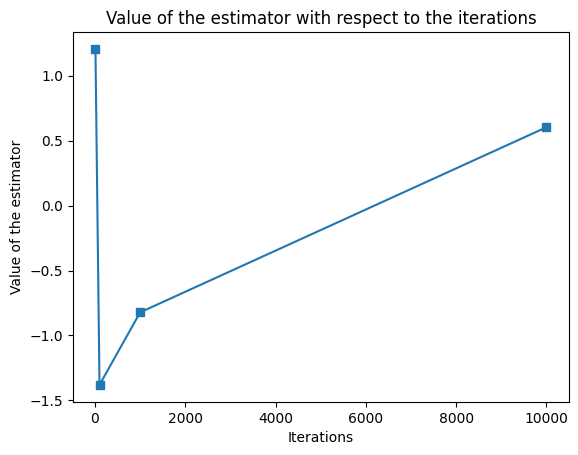

In [126]:
#Shift the mean of q
mu2 = 6 #second choice of mean for q

Ns = [10, 100, 1000, 10000] #sample sizes
M = 1000
#Compute the IS estimate for mu=mu2
delta_n_hat = IS(Ns[-1], mu2)
print(f"Estimation of the expectation : {delta_n_hat:.4f}")

IS_vec = np.vectorize((lambda x: IS(x, mu2)))
ISNs = IS_vec(Ns)


plt.xlabel("Iterations")
plt.ylabel("Value of the estimator")
plt.plot(Ns, ISNs, '-s')
plt.title("Value of the estimator with respect to the iterations");

In [127]:
# Compute empirical mean and variance for different sample sizes

Ns = [10, 100, 1000, 10000]
M = 1000

means = []
variances = []
for N in Ns:
    estimates = np.array([IS(N, mu2) for _ in range(M)])
    means.append(estimates.mean())
    variances.append(estimates.var(ddof=1))
    print(f"N={N}: mean = {estimates.mean():.4f}, variance = {estimates.var(ddof=1):.6f}")


N=10: mean = 0.3022, variance = 1.809742
N=100: mean = 0.0716, variance = 1.632606
N=1000: mean = -0.9972, variance = 0.707572
N=10000: mean = -0.1168, variance = 0.955274


We remark that the estimator with the shifted mean does not even converge to the expected mean and exhibits a much higher variance than the estimator with the non-shifted mean. Choosing an appropriate importance density is crucial.

In [128]:
def importance_weights(N, mu1, mu2):
  '''
  Compute the importance weights for two different means of q
  Parameters:
   - N : int
   - mu1 : float
   - mu2 : float
  Returns:
   - importance_weights_1 : np.array
   - importance_weights_2 : np.array
  '''
  Y1 = np.random.normal(loc = mu1, scale=np.sqrt(1.5), size=N)
  Y2 = np.random.normal(loc = mu2, scale=np.sqrt(1.5), size=N)
  #only keep non negative Y
  Y1 = Y1[Y1>=0]
  Y2 = Y2[Y2>=0]

  importance_weights_1 = p(Y1)/q(Y1, mu=mu1)
  importance_weights_2 = p(Y2)/q(Y2, mu=mu2)

  return (importance_weights_1/np.mean(importance_weights_1), importance_weights_2/np.mean(importance_weights_2))

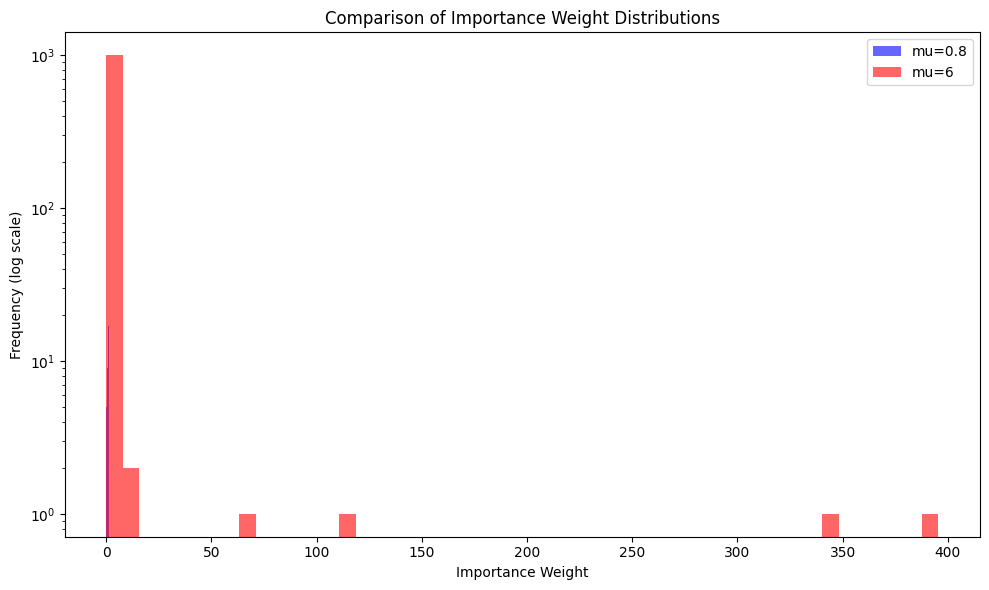

 Maximum weight value for mu=6 : 395.526224


In [129]:
### TEST ###
N=1000
weights1, weights2 = importance_weights(N, mu1, mu2)
plt.figure(figsize=(10,6))
plt.hist(weights1, bins=50, alpha=0.6, label=f'mu={mu1}', color='b')
plt.hist(weights2, bins=50, alpha=0.6, label=f'mu={mu2}', color='r')
plt.yscale('log')
plt.xlabel('Importance Weight')
plt.ylabel('Frequency (log scale)')
plt.title('Comparison of Importance Weight Distributions')
plt.legend()
plt.tight_layout()
plt.show()

print(f" Maximum weight value for mu={mu2} : {np.max(weights2):4f}")

We remark that when the sampling distribution is centered appropriately ($\mu=0.8$), the spread of importance weights is reasonable, and most samples contribute usefully to the result. When the proposal is poorly placed ($\mu=6$), weights are almost always zero or negligible, with only a few very large outliers, resulting in an estimator with high variance and poor practical convergence.

### **3.B Adaptative Importance Sampling**

#### **Question 4**

**Using the EM Algorithm to Maximize the Empirical Criterion in the Population Monte Carlo Algorithm**

The Expectation-Maximization (EM) algorithm is well-suited for maximizing the empirical criterion of step (iii) in the Population Monte Carlo algorithm, because this criterion takes the form of a weighted log-likelihood of a mixture, similar to a Gaussian mixture model with latent variables. Indeed, the only difference with the classical EM Algorithm is the weights $\tilde{\omega}_i$.

**Empirical criterion to maximize:**
$$
Q(\alpha, \mu, \Sigma) = \sum_{i=1}^n \tilde{\omega}_i^{(0)} \log \left( \sum_{j=1}^M \alpha_j \varphi(X_i^{(0)} ; \mu_j, \Sigma_j) \right)
$$
where $\tilde{\omega}_i^{(0)}$ are the normalized importance weights and $\varphi$ is the Gaussian density.

**Application of the EM algorithm:**  

We introduce latent variables $Z_i$ that indicate the component from which each observation $X_i$ originates.

**E-step (computation of weighted responsibilities):**
$$
\gamma_{ij} = P(Z_i = j | X_i, \theta_j^{(0)}) = \frac{\alpha_j \varphi(X_i ; \mu_j, \Sigma_j)}{\sum_{k=1}^M \alpha_k \varphi(X_i ; \mu_k, \Sigma_k)}
$$

**M-step (parameter update):**  

We maximize the expectation of the complete data log-likelihood, weighted by $\tilde{\omega}_i^{(0)}$:
$$
\alpha_j^{(1)} = \frac{\sum_{i=1}^n \tilde{\omega}_i^{(0)} \gamma_{ij}}{\sum_{i=1}^n \tilde{\omega}_i^{(0)}}
$$

$$
\mu_j^{(1)} = \frac{\sum_{i=1}^n \tilde{\omega}_i^{(0)} \gamma_{ij} X_i}{\sum_{i=1}^n \tilde{\omega}_i^{(0)} \gamma_{ij}}
$$
$$
\Sigma_j^{(1)} = \frac{\sum_{i=1}^n \tilde{\omega}_i^{(0)} \gamma_{ij} (X_i - \mu_j^{(1)})(X_i - \mu_j^{(1)})^T}{\sum_{i=1}^n \tilde{\omega}_i^{(0)} \gamma_{ij}}
$$

Thus, step (ii) of PMC corresponds to the E-step of EM (computation of weighted responsibilities), and step (iii) corresponds to the M-step (update of mixture parameters via maximization of the weighted criterion), until convergence.


### **3.C Application to a "banana"-shaped density**

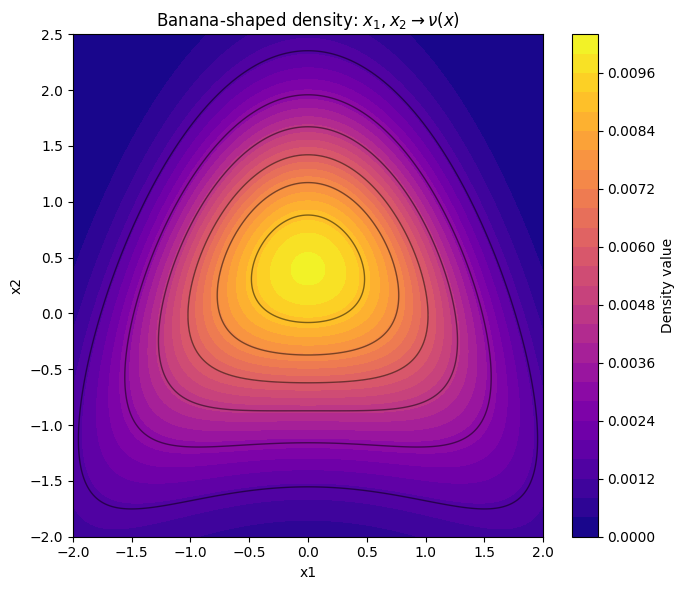

In [130]:
d = 5
sigma = np.eye(d)
mu = np.zeros(d)
b = 0.4

def special_phi(x1, x2, mu, sigma):
  """
  Computes the value of the banana-shaped density at point (x1, x2).
  Parameters:
   -x1 : np.array or float
   -x2 : np.array or float
   -mu : np.array
   -sigma : np.array
  Returns:
   - value of the banana-shaped density
  """
  x = np.zeros(d)
  x[0] = x1
  x[1] = x2 + b * (x1**2 - sigma[0, 0]**2)
  return multivariate_normal.pdf(x, mu, sigma)

xx = np.linspace(-2, 2, 300)
yy = np.linspace(-2, 2.5, 300)
X, Y = np.meshgrid(xx, yy)
Z = np.vectorize(lambda x1, x2: special_phi(x1, x2, mu, sigma))(X, Y)

plt.figure(figsize=(7, 6))

cf = plt.contourf(X, Y, Z, levels=30, cmap="plasma")
c = plt.contour(X, Y, Z, levels=8, colors='black', linewidths=1, alpha=0.5)

# plt.scatter(X.ravel(), Y.ravel(), color="white", s=1, alpha=0.1)

plt.colorbar(cf, label="Density value")
plt.title("Banana-shaped density: $x_1, x_2 \\to \\nu(x)$")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

In [131]:
# Parameters of the banana-shaped target
d = 5
b = 0.4
mu = np.zeros(d)
sigma = np.eye(d)

def nu_density(x):
  """Banana-shaped target density, up to normalization.
  Parameters:
   -x: np.array
  Returns:
   - value of the banana-shaped density at x
  """
  x = np.array(x)
  y = x.copy()
  y[1] = x[1] + b * (x[0]**2 - sigma[0, 0]**2)
  return multivariate_normal.pdf(y, mean=mu, cov=sigma)

# Population Monte Carlo Sampler
M = 3                     # Number of mixture components
N = 500                   # Number of samples per iteration
T = 10                    # Number of PMC iterations

# Initialization parameters
alphas = np.ones(M) / M #uniformly distributed among the clusters
mus = np.random.randn(M, d)
covs = np.array([np.eye(d) for _ in range(M)])

for t in range(T):
    # Build importance distribution: mixture of Gaussians q(x)
    X = np.zeros((N, d))

    # EM step for mixture parameters (E step)
    q_prob = np.zeros(N) #array containing the density of each sample X_i
    comp_idxs = np.random.choice(M, size=N, p=alphas) #we generate the random vector Z
    for i in range(N):
        k = comp_idxs[i]
        X[i] = np.random.multivariate_normal(mus[k], covs[k])
        q_prob[i] = sum(alphas[m] * multivariate_normal.pdf(X[i], mus[m], covs[m]) for m in range(M))

    # Compute normalized importance weights for the target
    nu = np.array([nu_density(x) for x in X])
    w = nu / q_prob
    w /= np.sum(w)  # normalized weights

    # EM step for mixture parameters (M step)
    # Responsibilities
    resp = np.zeros((N, M))
    for m in range(M):
        resp[:, m] = alphas[m] * multivariate_normal.pdf(X, mus[m], covs[m])
    resp = (resp.T / np.sum(resp, axis=1)).T  # shape (N, M) #gamma in the formula above
    resp_weighted = w[:, np.newaxis] * resp

    # Update mixture weights
    alphas = resp_weighted.sum(axis=0)
    alphas /= alphas.sum()
    # Update means
    mus = (resp_weighted.T @ X) / resp_weighted.sum(axis=0)[:, np.newaxis]
    # Update covariances
    for m in range(M):
        diff = X - mus[m]
        covs[m] = (resp_weighted[:, m][:, None] * diff).T @ diff / resp_weighted[:, m].sum()
        # Regularization to ensure positive-definite
        covs[m] += 1e-6 * np.eye(d)

# Draw samples according to the final proposal and reweight
K = 10000
final_comp_idx = np.random.choice(M, size=K, p=alphas)
X_final = np.array([np.random.multivariate_normal(mus[m], covs[m]) for m in final_comp_idx])
q_prob_final = np.array([
    sum(alphas[m] * multivariate_normal.pdf(x, mus[m], covs[m]) for m in range(M))
    for x in X_final
])
nu_final = np.array([nu_density(x) for x in X_final])
w_final = nu_final / q_prob_final
w_final /= np.sum(w_final)

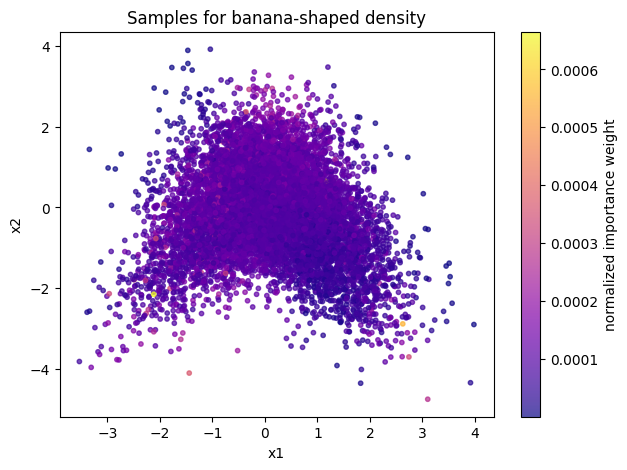

In [132]:
# Visualize the reweighted samples (banana shape in (x1,x2))
plt.figure(figsize=(7,5))
plt.scatter(X_final[:,0], X_final[:,1], c=w_final, cmap="plasma", alpha=0.7, s=10)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples for banana-shaped density")
plt.colorbar(label="normalized importance weight")
plt.show()

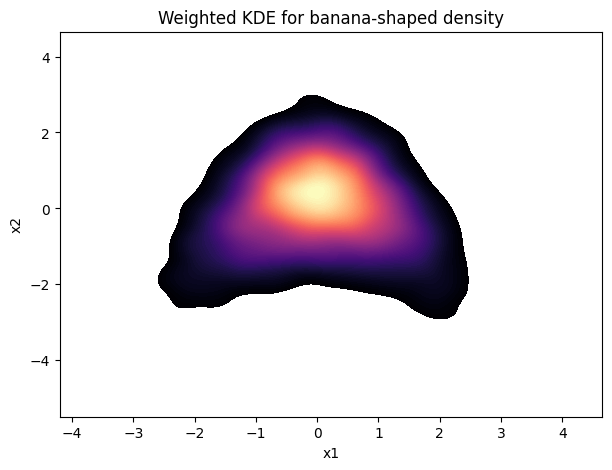

In [133]:
plt.figure(figsize=(7,5))
sns.kdeplot(
    x=X_final[:,0], y=X_final[:,1], weights=w_final,
    cmap="magma", fill=True, thresh=0.05, levels=100
)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Weighted KDE for banana-shaped density")
plt.show()


We retrieve well the shape of the true density (in 2D).